In [2]:
pip -V

pip 25.0 from /users/k23070952/.local/lib/python3.9/site-packages/pip (python 3.9)
Note: you may need to restart the kernel to use updated packages.


In [1]:
cd ~/MultiFidelity-ProcessOpt/Perovskites/

/cephfs/volumes/hpc_home/k23070952/a774a32b-b8f8-42f8-b661-406a5dd49fd8/MultiFidelity-ProcessOpt/Perovskites


In [1]:
pip list

Package                       Version                 Editable project location
----------------------------- ----------------------- --------------------------------------------------------------------------------------------------------------------
about-time                    4.2.1
absl-py                       2.1.0
accelerate                    1.5.1
aiohappyeyeballs              2.4.3
aiohttp                       3.11.7
aiosignal                     1.3.1
alabaster                     0.7.12
alembic                       1.14.1
alive-progress                3.2.0
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
annotated-types               0.7.0
ansicolors                    1.1.8
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array_record                  0.5.1
arrow                         1.2.2
astroid               

In [2]:
from olympus import Surface, Campaign
from atlas.planners.gp.planner import GPPlanner

In [3]:
from olympus.datasets import Dataset

In [2]:
#!/usr/bin/env python

import json
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy

from olympus.datasets import Dataset
from olympus.objects import (
	ParameterContinuous,
	ParameterDiscrete, 
	ParameterCategorical, 
	ParameterVector)

from olympus.campaigns import ParameterSpace, Campaign

from atlas.planners.multi_fidelity.planner import MultiFidelityPlanner



In [3]:
# config
dataset = Dataset(kind='perovskites')
NUM_RUNS = 10
# BUDGET = 30
COST_BUDGET = 50 # 200.
NUM_INIT_DESIGN = 10
NUM_CHEAP = 8

# lookup table
# organic --> cation --> anion --> bandgap_hse06/bandgap_gga
LOOKUP = pickle.load(open('0.Data/lookup_table.pkl', 'rb'))
# print(lookup.keys())
# print(lookup['Ethylammonium']['Ge']['F'].keys())



In [4]:
dataset.param_space

In [5]:

def build_options_descriptors(json_file):
	with open(json_file, 'r') as f:
		content = json.load(f)

	options = list(content.keys())
	descriptors = [list(content[opt].values()) for opt in options]

	return options, descriptors

def measure(params, s):
	# high-fidelity is hse06, low-fidelity is gga
	if s == 1.0:
		measurement = np.amin(
			LOOKUP[params.organic.capitalize()][params.cation][params.anion]['bandgap_hse06']
		)
	elif s == 0.1:
		measurement = np.amin(
			LOOKUP[params.organic.capitalize()][params.cation][params.anion]['bandgap_gga']
		)
	return measurement

def get_min_hse06_bandgap(param_space):
	organic_options = [o.capitalize() for o in param_space[1].options]
	cation_options = [o.capitalize() for o in param_space[2].options]
	anion_options = [o.capitalize() for o in param_space[3].options]

	hse06_bandgaps = []
	for organic_option in organic_options:
		for cation_option in cation_options:
			for anion_option in anion_options:
				hse06_bandgaps.append(
					np.amin(
						LOOKUP[organic_option][cation_option][anion_option]['bandgap_hse06']
					)
				)
	min_hse06_bandgap = np.amin(hse06_bandgaps)
	return min_hse06_bandgap

def compute_cost(params):
	costs = params[:,0].astype(float)
	return np.sum(costs)



In [6]:

# build parameter space
param_space = ParameterSpace()

# fidelity param
param_space.add(ParameterDiscrete(name='s', options=[0.1, 1.0], low=0.1, high=1.0))
for param in dataset.param_space: # add perovskite component parameters ('organic', 'cation', and 'anion')
	print(param)
	param_space.add(param)


all_data = []
min_hse06_bandgap = get_min_hse06_bandgap(param_space)
print('MIN HSE06 BANDGAP : ', min_hse06_bandgap)
# >>> MIN HSE06 BANDGAP :  1.5249
# hydrazinium	Sn	I



Categorical (name='organic', num_opts: 16, options=['ethylammonium', 'propylammonium', 'butylammonium', 'isopropylammonium', 'dimethylammonium', 'acetamidinium', 'methylammonium', 'guanidinium', 'hydroxylammonium', 'formamidinium', 'tetramethylammonium', 'hydrazinium', 'ammonium', 'trimethylammonium', 'azetidinium', 'imidazolium'], descriptors=[[-0.460099995136261, -0.2239799946546554, 1.3964999914169312, -1.8414201736450195, 1.2615654468536377, 69.08699798583984], [-0.460099995136261, -0.2239799946546554, 1.3964999914169312, -1.8414201736450195, 1.2615654468536377, 69.08699798583984], [-0.460099995136261, -0.2239799946546554, 1.3964999914169312, -1.8414201736450195, 1.2615654468536377, 69.08699798583984], [-0.460099995136261, -0.2239799946546554, 1.3964999914169312, -1.8414201736450195, 1.2615654468536377, 69.08699798583984], [-0.460099995136261, -0.2239799946546554, 1.3964999914169312, -1.8414201736450195, 1.2615654468536377, 69.08699798583984], [-0.460099995136261, -0.22397999465465

In [11]:
import time

timing_data = []
for run_ix in range(NUM_RUNS):

	campaign = Campaign()
	campaign.set_param_space(param_space)

	planner = MultiFidelityPlanner(
		goal='minimize',
		init_design_strategy='random',
		num_init_design=NUM_INIT_DESIGN,
		use_descriptors=True,
		batch_size=1,
		acquisition_optimizer_kind='pymoo',
		fidelity_params=0,
		fidelities=[0.1, 1.],
	)

	planner.set_param_space(param_space)

	COST = 0.

	target_rec_measurements = []
	iter_ = 0
	while COST < COST_BUDGET:
		print(f'\nRUN : {run_ix+1}/{NUM_RUNS}\tITER : {iter_+1}\tCOST : {COST}\n')
		start_time = time.time()  # 시작 시간 저장
		if iter_ % NUM_CHEAP == 0:
			planner.set_ask_fidelity(1.0)
		else:
			planner.set_ask_fidelity(0.1)

		samples = planner.recommend(campaign.observations)
		end_time = time.time()  # 시작 시간 저장
		time_taken = end_time-start_time
		print(f"Time: {time_taken}s")
		
		timing_data.append([run_ix, iter_, time_taken])
		for sample in samples:
			measurement = measure(sample, sample.s)
			campaign.add_observation(sample, measurement)

			print('SAMPLE : ', sample)
			print('MEASUREMENT : ', measurement)

			iter_+=1

		# do a check to see if model will find the optimal
		if campaign.num_obs > NUM_INIT_DESIGN:
			# make greedy recommendation on the target fidelity
			rec_sample = planner.recommend_target_fidelity(batch_size=1)[0]
			rec_measurement = measure(rec_sample, rec_sample.s)
			print('')
			print('REC SAMPLE : ', rec_sample)
			print('REC MEASUREMENT : ', rec_measurement)
			print('')
			target_rec_measurements.append(rec_measurement)
			# kill the run if we have found the lowest hse06 bandgap
			# on the most recent high-fidelity measurement
			if rec_measurement == min_hse06_bandgap:
				print('found the min hse06 bandgap!')
				break
		else:
			target_rec_measurements.append(measurement)
			# kill the run if we have found the lowest hse06 bandgap
			# on the most recent high-fidelity measurement
			if measurement == min_hse06_bandgap and samples[0].s == 1.:
				print('found the min hse06 bandgap!')
				break

		
		COST = compute_cost(params=campaign.observations.get_params())



	s_col = campaign.observations.get_params()[:, 0]
	x0_col = campaign.observations.get_params()[:, 1]
	x1_col = campaign.observations.get_params()[:, 2]
	x2_col = campaign.observations.get_params()[:, 3]

	obj0_col = np.array(target_rec_measurements) #campaign.observations.get_values()

	data = pd.DataFrame({
		's': s_col,
		'organic': x0_col,
		'cation': x1_col,
		'anion': x2_col,
		'obj': obj0_col,
	})
	all_data.append(data)
	pickle.dump(all_data, open('mf_results.pkl', 'wb'))

timing_df = pd.DataFrame(timing_data, columns=['run_ix', 'iter', 'time_taken'])
timing_df.to_csv('timing_results.csv', index=False)

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────


RUN : 1/10	ITER : 1	COST : 0.0



ATLAS [WARNING] Setting ask fidelity level to 1.0

ATLAS [INFO] Generating 1 initial design points (batch 1/10)

Time: 0.005166053771972656s
SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Sn, anion = I)
MEASUREMENT :  1.9713

RUN : 1/10	ITER : 2	COST : 1.0



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 2/10)

Time: 0.004616975784301758s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Ge, anion = Br)
MEASUREMENT :  1.6643

RUN : 1/10	ITER : 3	COST : 1.1



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 3/10)

Time: 0.004981517791748047s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Ge, anion = Br)
MEASUREMENT :  2.2149

RUN : 1/10	ITER : 4	COST : 1.2000000000000002



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 4/10)

Time: 0.005060911178588867s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Ge, anion = F)
MEASUREMENT :  4.1048

RUN : 1/10	ITER : 5	COST : 1.3000000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 5/10)

Time: 0.004999876022338867s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Ge, anion = Br)
MEASUREMENT :  1.6643

RUN : 1/10	ITER : 6	COST : 1.4000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 6/10)

Time: 0.004955768585205078s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  3.5046

RUN : 1/10	ITER : 7	COST : 1.5000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 7/10)

Time: 0.00565791130065918s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Ge, anion = I)
MEASUREMENT :  1.6555

RUN : 1/10	ITER : 8	COST : 1.6000000000000005



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 8/10)

Time: 0.004777431488037109s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Pb, anion = F)
MEASUREMENT :  3.9164

RUN : 1/10	ITER : 9	COST : 1.7000000000000002



ATLAS [WARNING] Setting ask fidelity level to 1.0

ATLAS [INFO] Generating 1 initial design points (batch 9/10)

Time: 0.005653858184814453s
SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Sn, anion = F)
MEASUREMENT :  4.8004

RUN : 1/10	ITER : 10	COST : 2.7



ATLAS [WARNING] Setting ask fidelity level to 0.1

ATLAS [INFO] Generating 1 initial design points (batch 10/10)

Time: 0.005392789840698242s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Sn, anion = F)
MEASUREMENT :  3.2677

RUN : 1/10	ITER : 11	COST : 2.8000000000000003



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-4.4409e-16]), std = tensor([1.0541])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.069 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 25.998584985733032s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Pb, anion = Cl)
MEASUREMENT :  2.3908


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Sn, anion = F)
REC MEASUREMENT :  3.985


RUN : 1/10	ITER : 12	COST : 2.9000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-2.8260e-16]), std = tensor([1.0488])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.074 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 26.080373764038086s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Sn, anion = F)
MEASUREMENT :  3.8068


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  2.7559


RUN : 1/10	ITER : 13	COST : 3.0000000000000004



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-3.7007e-16]), std = tensor([1.0445])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.092 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 26.28024911880493s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Pb, anion = F)
MEASUREMENT :  3.7495


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydrazinium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.8474


RUN : 1/10	ITER : 14	COST : 3.1000000000000005



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.4161e-17]), std = tensor([1.0408])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.092 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 25.929326057434082s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Ge, anion = Cl)
MEASUREMENT :  2.8878


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.3704


RUN : 1/10	ITER : 15	COST : 3.2000000000000006



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-2.2204e-16]), std = tensor([1.0377])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.079 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 26.27401375770569s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Ge, anion = I)
MEASUREMENT :  1.6986


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  4.4938


RUN : 1/10	ITER : 16	COST : 3.3000000000000007



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9606e-17]), std = tensor([1.0351])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.088 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 26.188774347305298s
SAMPLE :  ParamVector(s = 0.1, organic = imidazolium, cation = Pb, anion = Br)
MEASUREMENT :  2.0313


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Pb, anion = I)
REC MEASUREMENT :  2.7329


RUN : 1/10	ITER : 17	COST : 3.4000000000000004



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-4.9960e-16]), std = tensor([1.0328])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.097 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 26.406298398971558s
SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Ge, anion = F)
MEASUREMENT :  5.4104


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.5517


RUN : 1/10	ITER : 18	COST : 4.4



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-4.7021e-16]), std = tensor([1.0308])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.097 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 26.57853627204895s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Ge, anion = Br)
MEASUREMENT :  2.6513


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  5.2155


RUN : 1/10	ITER : 19	COST : 4.5



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-6.7847e-16]), std = tensor([1.0290])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.107 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 26.754382371902466s
SAMPLE :  ParamVector(s = 0.1, organic = trimethylammonium, cation = Ge, anion = F)
MEASUREMENT :  4.0662


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Ge, anion = Cl)
REC MEASUREMENT :  3.6438


RUN : 1/10	ITER : 20	COST : 4.6



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-4.6746e-16]), std = tensor([1.0274])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.107 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 26.984660148620605s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  1.9337


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Sn, anion = I)
REC MEASUREMENT :  1.9374


RUN : 1/10	ITER : 21	COST : 4.699999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-6.1062e-16]), std = tensor([1.0260])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.102 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 26.860416412353516s
SAMPLE :  ParamVector(s = 0.1, organic = hydrazinium, cation = Ge, anion = I)
MEASUREMENT :  1.3701


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Pb, anion = I)
REC MEASUREMENT :  2.2316


RUN : 1/10	ITER : 22	COST : 4.799999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-7.4015e-16]), std = tensor([1.0247])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.098 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 26.82475709915161s
SAMPLE :  ParamVector(s = 0.1, organic = hydroxylammonium, cation = Sn, anion = Br)
MEASUREMENT :  1.9845


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Ge, anion = F)
REC MEASUREMENT :  5.9083


RUN : 1/10	ITER : 23	COST : 4.899999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-3.6335e-16]), std = tensor([1.0235])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.098 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 27.240508556365967s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Pb, anion = F)
MEASUREMENT :  2.8657


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = dimethylammonium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.3139


RUN : 1/10	ITER : 24	COST : 4.999999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-6.4683e-16]), std = tensor([1.0225])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.098 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 27.071587085723877s
SAMPLE :  ParamVector(s = 0.1, organic = imidazolium, cation = Sn, anion = Cl)
MEASUREMENT :  2.3972


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Pb, anion = I)
REC MEASUREMENT :  2.4638


RUN : 1/10	ITER : 25	COST : 5.1



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.9429e-16]), std = tensor([1.0215])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.093 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 28.425234079360962s
SAMPLE :  ParamVector(s = 1.0, organic = azetidinium, cation = Sn, anion = F)
MEASUREMENT :  4.4118


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.9855


RUN : 1/10	ITER : 26	COST : 6.1



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-1.4211e-16]), std = tensor([1.0206])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.098 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 28.765717267990112s
SAMPLE :  ParamVector(s = 0.1, organic = butylammonium, cation = Pb, anion = I)
MEASUREMENT :  1.9361


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Sn, anion = F)
REC MEASUREMENT :  4.1905


RUN : 1/10	ITER : 27	COST : 6.199999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.4091e-16]), std = tensor([1.0198])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.098 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 29.04991602897644s
SAMPLE :  ParamVector(s = 0.1, organic = isopropylammonium, cation = Pb, anion = F)
MEASUREMENT :  4.137


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Pb, anion = I)
REC MEASUREMENT :  2.6193


RUN : 1/10	ITER : 28	COST : 6.299999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.7961e-16]), std = tensor([1.0190])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.121 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 28.90234899520874s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Pb, anion = Br)
MEASUREMENT :  2.378


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Pb, anion = Cl)
REC MEASUREMENT :  4.1047


RUN : 1/10	ITER : 29	COST : 6.399999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.2601e-16]), std = tensor([1.0184])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.098 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 29.00190544128418s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Ge, anion = Br)
MEASUREMENT :  1.8833


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Pb, anion = Br)
REC MEASUREMENT :  3.144


RUN : 1/10	ITER : 30	COST : 6.499999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-1.5313e-17]), std = tensor([1.0177])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.089 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 29.406525373458862s
SAMPLE :  ParamVector(s = 0.1, organic = imidazolium, cation = Pb, anion = I)
MEASUREMENT :  1.5309


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Sn, anion = F)
REC MEASUREMENT :  4.9553


RUN : 1/10	ITER : 31	COST : 6.599999999999998



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([6.2913e-17]), std = tensor([1.0171])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.099 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 29.547251224517822s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Ge, anion = F)
MEASUREMENT :  3.925


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Sn, anion = I)
REC MEASUREMENT :  1.5456


RUN : 1/10	ITER : 32	COST : 6.6999999999999975



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-7.1627e-18]), std = tensor([1.0165])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.126 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 29.866581439971924s
SAMPLE :  ParamVector(s = 0.1, organic = ethylammonium, cation = Sn, anion = F)
MEASUREMENT :  2.8524


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Ge, anion = F)
REC MEASUREMENT :  5.5038


RUN : 1/10	ITER : 33	COST : 6.800000000000001



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-1.1102e-16]), std = tensor([1.0160])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.122 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 30.09570622444153s
SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Pb, anion = Cl)
MEASUREMENT :  3.8987


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Pb, anion = Br)
REC MEASUREMENT :  3.186


RUN : 1/10	ITER : 34	COST : 7.800000000000001



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-6.7286e-17]), std = tensor([1.0155])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.099 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 30.29969835281372s
SAMPLE :  ParamVector(s = 0.1, organic = tetramethylammonium, cation = Sn, anion = Cl)
MEASUREMENT :  2.9327


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = ethylammonium, cation = Sn, anion = Cl)
REC MEASUREMENT :  2.2931


RUN : 1/10	ITER : 35	COST : 7.9



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-8.1634e-17]), std = tensor([1.0150])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.095 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 30.2178852558136s
SAMPLE :  ParamVector(s = 0.1, organic = acetamidinium, cation = Sn, anion = I)
MEASUREMENT :  1.2292


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = imidazolium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.4152


RUN : 1/10	ITER : 36	COST : 8.0



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-1.3323e-16]), std = tensor([1.0146])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.095 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 30.282140970230103s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Pb, anion = Cl)
MEASUREMENT :  2.3229


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.1209


RUN : 1/10	ITER : 37	COST : 8.1



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-3.6699e-16]), std = tensor([1.0142])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.095 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 30.65236496925354s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Sn, anion = Cl)
MEASUREMENT :  1.4646


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Pb, anion = F)
REC MEASUREMENT :  5.7128


RUN : 1/10	ITER : 38	COST : 8.2



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-6.3013e-16]), std = tensor([1.0138])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.1 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 30.810218811035156s
SAMPLE :  ParamVector(s = 0.1, organic = methylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  2.0343


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Sn, anion = Br)
REC MEASUREMENT :  2.4938


RUN : 1/10	ITER : 39	COST : 8.299999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-4.4993e-16]), std = tensor([1.0134])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.096 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 30.739381790161133s
SAMPLE :  ParamVector(s = 0.1, organic = dimethylammonium, cation = Pb, anion = I)
MEASUREMENT :  1.607


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Ge, anion = Cl)
REC MEASUREMENT :  4.4938


RUN : 1/10	ITER : 40	COST : 8.399999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-3.4730e-16]), std = tensor([1.0131])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.11 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 31.044516563415527s
SAMPLE :  ParamVector(s = 0.1, organic = azetidinium, cation = Ge, anion = Cl)
MEASUREMENT :  2.6892


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = tetramethylammonium, cation = Ge, anion = Br)
REC MEASUREMENT :  3.4691


RUN : 1/10	ITER : 41	COST : 8.5



ATLAS [WARNING] Setting ask fidelity level to 1.0

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-8.8818e-17]), std = tensor([1.0127])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.106 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 31.212053775787354s
SAMPLE :  ParamVector(s = 1.0, organic = isopropylammonium, cation = Ge, anion = Cl)
MEASUREMENT :  4.0419


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = acetamidinium, cation = Pb, anion = I)
REC MEASUREMENT :  2.4574


RUN : 1/10	ITER : 42	COST : 9.5



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-1.1373e-16]), std = tensor([1.0124])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.12 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 31.51220726966858s
SAMPLE :  ParamVector(s = 0.1, organic = propylammonium, cation = Pb, anion = Br)
MEASUREMENT :  2.1145


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = methylammonium, cation = Pb, anion = I)
REC MEASUREMENT :  2.4638


RUN : 1/10	ITER : 43	COST : 9.6



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-3.1985e-16]), std = tensor([1.0121])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.116 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 31.56888747215271s
SAMPLE :  ParamVector(s = 0.1, organic = ammonium, cation = Ge, anion = Cl)
MEASUREMENT :  2.1817


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = propylammonium, cation = Sn, anion = I)
REC MEASUREMENT :  2.0056


RUN : 1/10	ITER : 44	COST : 9.7



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-5.0089e-16]), std = tensor([1.0118])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.116 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 31.822162628173828s
SAMPLE :  ParamVector(s = 0.1, organic = trimethylammonium, cation = Pb, anion = F)
MEASUREMENT :  3.4595


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = butylammonium, cation = Sn, anion = F)
REC MEASUREMENT :  4.8539


RUN : 1/10	ITER : 45	COST : 9.799999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-6.9641e-16]), std = tensor([1.0116])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.173 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 31.982697248458862s
SAMPLE :  ParamVector(s = 0.1, organic = guanidinium, cation = Ge, anion = Br)
MEASUREMENT :  2.091


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = trimethylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  2.5369


RUN : 1/10	ITER : 46	COST : 9.899999999999999



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-3.0099e-16]), std = tensor([1.0113])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.107 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = hydroxylammonium, cation = Ge, anion = I)
REC MEASUREMENT :  2.1098


RUN : 2/10	ITER : 221	COST : 47.2



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.31 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 85.91981935501099s


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = guanidinium, cation = Sn, anion = Cl)
REC MEASUREMENT :  3.3492


RUN : 2/10	ITER : 221	COST : 47.2



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.419 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

Time: 87.53698825836182s


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...


REC SAMPLE :  ParamVector(s = 1.0, organic = formamidinium, cation = Pb, anion = Cl)
REC MEASUREMENT :  3.2914


RUN : 2/10	ITER : 221	COST : 47.2



ATLAS [WARNING] Setting ask fidelity level to 0.1

───────────────────── Training regression surrogate model ──────────────────────

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.317 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:477: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/botorch/models/gpytorch.py:239: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)
/users/k23070952/.local/lib/python3.9/site-packages/pymoo/operators/repair/rounding.py:18: RuntimeWarning: invalid value encountered in cast
  return np.around(X).astype(int)
/users/k230709

KeyboardInterrupt: 

In [20]:
timing_df = pd.DataFrame(timing_data, columns=['run_ix', 'iter', 'time_taken'])
timing_df.to_csv('timing_results.csv', index=False)

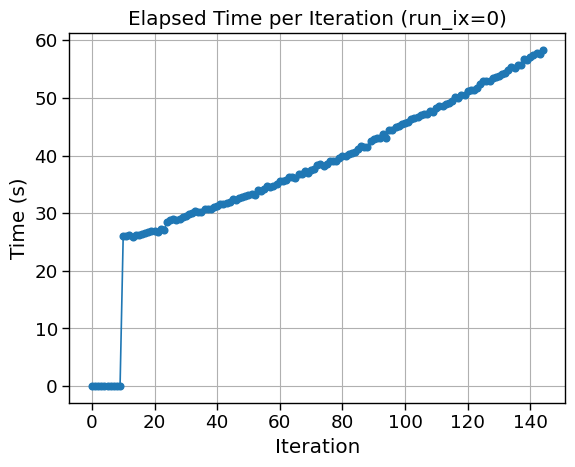

In [18]:
import matplotlib.pyplot as plt
# 첫번째 컬럼이 0인 것만 추출
filtered = [row for row in timing_data if row[0] == 0]

# 두번째 컬럼(x축), 세번째 컬럼(y축) 추출
x = [row[1] for row in filtered]
y = [row[2] for row in filtered]

plt.plot(x, y, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Time (s)')
plt.title('Elapsed Time per Iteration (run_ix=0)')
plt.grid(True)
plt.show()